In [1]:
# Подключение к Google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
PATH = '/content/drive/My Drive/GU_neural_network/'

## Практическое задание

<ol>
    <li>Попробуйте обучить нейронную сеть на TensorFlow 2 на любом датасете imdb_reviews. 
        Опишите в комментарии к уроку - какой результата вы добились от нейросети? Что помогло вам улучшить ее точность?<br><br>
    </li>
    <li>*2. Поработайте с документацией TensorFlow 2. Найдите полезные команды не разобранные на уроке.</li>
    
    
</ol>

## Библотеки

In [3]:
import tensorflow as tf
print(tf.__version__)

2.2.0-rc3


In [0]:
import tensorflow_datasets as tfds
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import random

In [5]:
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

GPU is NOT AVAILABLE


In [0]:
tf.random.set_seed(1)
np.random.seed(1)
random.seed(1)
tf.compat.v1.random.set_random_seed(1)

## Подготовка данных

In [0]:
# The full `train` split and the full `test` split as two distinct datasets.
(train_ds, valid_ds, test_ds), info = tfds.load('imdb_reviews/subwords32k',
                                        data_dir=PATH, 
                                        split=['train[:40%]+train[-40%:]', 'train[40%:60%]', 'test'],
                                        # Return (example, label) pairs from the dataset (instead of a dictionary).
                                        as_supervised=True,
                                        # Also return the `info` structure. 
                                        with_info=True)


In [8]:
encoder = info.features['text'].encoder
print ('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 32650


In [9]:
info.features

FeaturesDict({
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'text': Text(shape=(None,), dtype=tf.int64, encoder=<SubwordTextEncoder vocab_size=32650>),
})

In [10]:
for train_example, train_label in train_ds.take(1):
  print('Encoded text:', train_example)
  print('Label:', train_label.numpy())

Encoded text: tf.Tensor(
[   56    18    41   496   674    59     3   574 32433    25    34 21905
    10    39  1626  8210    49   548 17768     3  1730    29   112   520
     2    24    14   256   382    34    72   312   335    10  1216     3
   422    72   112   170   106    33  8157    14    59 32433    11  1133
  1964     3    56    27     8    41   476 15843 32426  1504  4185  2692
     3    19    96  2143   199    77   178    66     1 27162   381 15791
    77   281    72  5479    22  5693 32509     3  4147 24625 11296 24690
    50  1849 27610     2     5    54  4184 32439   157  2520    21  8210
    18   223    24     4  2143  1041 14185    10     4    27    13    18
  5414     6   111   188  4811     3    12   274  1357    13    84    29
   154    46   204     2 11717   758 32433    11    46  1626  8003 32433
    11    68  1417     3    12   106  1403   951   175    37 32440], shape=(143,), dtype=int64)
Label: 0


In [0]:
BUFFER_SIZE = 20000

train_batches = (
    train_ds
    .shuffle(BUFFER_SIZE)
    .padded_batch(32))
valid_batches = (
    valid_ds
    .padded_batch(32))

test_batches = (
    test_ds
    .padded_batch(32))

## Подготовка и анализ моделей

### Функция базовая модель

In [0]:
def baseline_model(name='baseline', vocab_size=32650):
  # Build the model.
  model = keras.Sequential(name=name, layers=[
    keras.layers.Embedding(vocab_size, 16),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='relu')
    ])
  

  # Compile the model
  model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'binary_crossentropy'])
  return model

In [0]:
def second_model(name='second_model', vocab_size=32650, l1=0.01):
  # Build the model.
  size = 8
  model = keras.Sequential(name=name, layers=[
    keras.layers.Embedding(vocab_size, size),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(size , activation='tanh'),
    keras.layers.GaussianDropout(rate=0.5),
    keras.layers.Dense(size , activation='tanh'),
    keras.layers.GaussianDropout(rate=0.9),
    keras.layers.Dense(1, activation='tanh')
    ])
  

  # Compile the model
  model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'binary_crossentropy'])
  return model

In [0]:
def best_model(name='best_model', vocab_size=32650, l1=0.01):
  # Build the model.
  size = 8
  model = keras.Sequential(name=name, layers=[
    keras.layers.Embedding(vocab_size, size),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(size , activation='tanh', kernel_regularizer=tf.keras.regularizers.l1(l1)),
    keras.layers.Dense(1, activation='tanh')
    ])
  

  # Compile the model
  model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'binary_crossentropy'])
  return model

In [0]:
def init_models():
  tf.random.set_seed(1)
  np.random.seed(1)
  random.seed(1)
  tf.compat.v1.random.set_random_seed(1)

  models = []
  models.append(baseline_model())
  models.append(second_model())
  models.append(best_model())
  return models

In [16]:
history = {}
i = 0

for model in init_models():
  i+= 1
  print(f'{i}. {model.name}  ')
  history[model.name] = model.fit(train_batches,
                      epochs=50,
                      validation_data=valid_batches, 
                      verbose=0, 
                      shuffle=False, 
                      validation_steps=30)
  loss, accuracy, binary_crossentropy = model.evaluate(test_batches, verbose=0)
  print(f'Accuracy: {accuracy}  ')
  print(f'Binary_crossentropy: {binary_crossentropy}  ')
  model.summary()

1. baseline  
Accuracy: 0.8672400116920471  
Binary_crossentropy: 1.3910231590270996  
Model: "baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          522400    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 522,689
Trainable params: 522,689
Non-trainable params: 0
_________________________________________________________________
2. second_model  
Accuracy: 0.8144800066947937  
Binary_crossentropy: 0.4794754981994629  
Model: "second_model"
__________________________________________________

Epoch = 30
1. baseline  
Accuracy: 0.8654800057411194  
Binary_crossentropy: 1.2368383407592773  

2. second_model  
Accuracy: 0.8620399832725525  
Binary_crossentropy: 0.4312247633934021   
3. best_model  
Accuracy: 0.8834800124168396  
Binary_crossentropy: 0.5245357751846313 

In [0]:
def plot_history(histories, key='binary_crossentropy'):
  plt.figure(figsize=(16,10))

  for name, history in histories.items():
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])

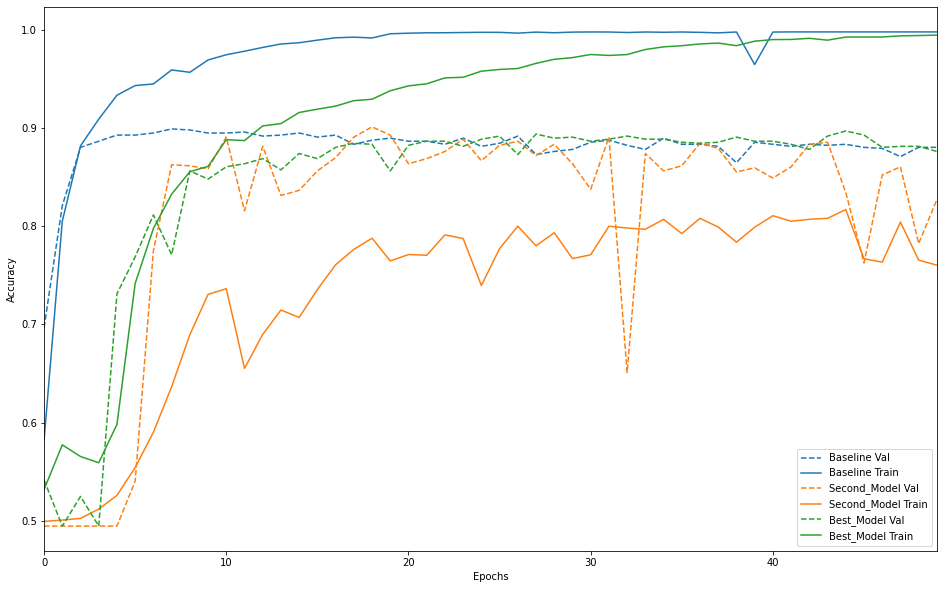

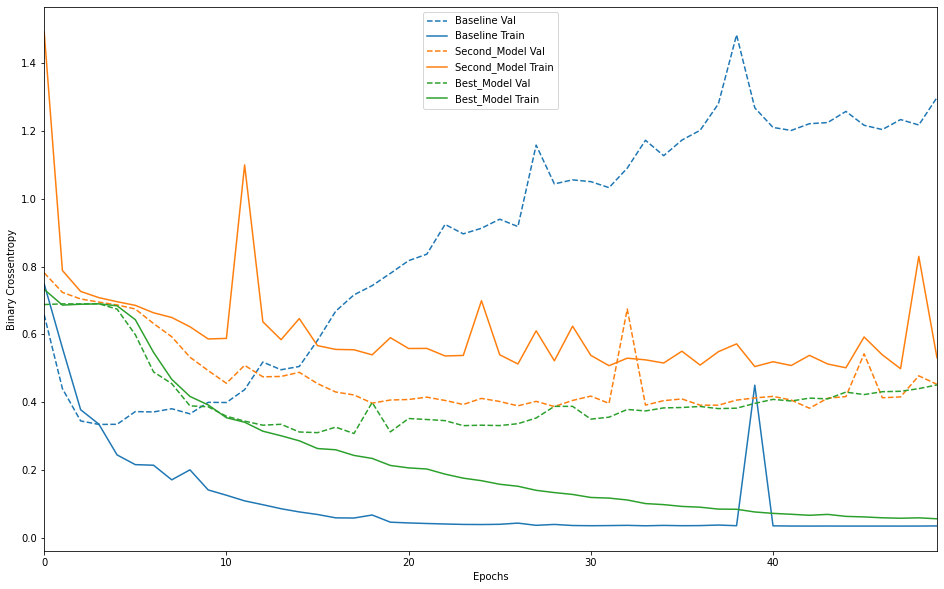

In [18]:
select_list = ['baseline', 'second_model',  'best_model']
filter_history = {k: v for k, v in history.items() if k in select_list}
plot_history(filter_history, key='accuracy')
plot_history(filter_history)